# 네이버 영화리뷰 감성분석 도전하기

## 데이터 준비 와 확인

In [9]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


## 데이터로더 구성
    * 데이터의 중복 제거
    * NaN 결측치 제거
    * 한국어 토크나이저로 토큰화
    * 불용어(Stopwords) 제거
    * 사전word_to_index 구성
    * 텍스트 스트링을 사전 인덱스 스트링으로 변환
    * X_train, y_train, X_test, y_test, word_to_index 리턴

In [12]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    # 데이터의 중복 제거
    train_data = train_data.drop_duplicates(['document'],ignore_index = True)
    test_data = test_data.drop_duplicates(['document'],ignore_index = True)
    
    # NaN 결측치 제거
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    
    # 한국어 토크나이저로 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words) # Counter 클래스는 iterable의 원소의 개수를 셀 때 편리하게 사용. 유니크한 원소의 이름들은 딕셔너리 key로, 각 원소의 카운트는 딕셔너리의 value로 저장
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]    
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

        
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [14]:
#  텍스트 스트링을 사전 인덱스 스트링으로 변환
index_to_word = {index:word for word, index in word_to_index.items()}

In [25]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 모든 문장은 <BOS>로 시작 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [26]:
# encode된 텍스트가 정상적으로 decode 되는지 확인
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 모델 구성을 위한 데이터 분석 및 가공
    * 데이터셋 내 문장 길이 분포
    * 적절한 최대 문장 길이 지정
    * keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [28]:
#  데이터셋 내 문장 길이 분포

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


한 최대 문장 길이 지정<br>
 *  전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함 (maxlen : 41)

In [29]:
import tensorflow as tf

# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가 - padding 방식 앞쪽('pre') : 성능 좋음

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='pre',
                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='pre',
                                       maxlen=maxlen)
print(X_train.shape)

(146182, 41)


## 모델 구성 및 validation set 구성
    모델은 3가지 이상 다양하게 구성하여 실험

In [30]:
# 훈련용 데이터셋 146182건 중 40000을 분리하여 검증셋(validation set) 생성

# validation set 40000건 분리
x_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


In [14]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

### RNN 모델

In [15]:
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### CNN 모델

In [16]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

###  GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [17]:
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련 개시

In [18]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_rnn = model_rnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 21s 8ms/step - loss: 0.5876 - accuracy: 0.7104 - val_loss: 0.4688 - val_accuracy: 0.8339
Epoch 2/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3968 - accuracy: 0.8482 - val_loss: 0.3686 - val_accuracy: 0.8460
Epoch 3/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3311 - accuracy: 0.8652 - val_loss: 0.3589 - val_accuracy: 0.8454
Epoch 4/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3111 - accuracy: 0.8744 - val_loss: 0.3527 - val_accuracy: 0.8493
Epoch 5/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2982 - accuracy: 0.8804 - val_loss: 0.3587 - val_accuracy: 0.8466
Epoch 6/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2870 - accuracy: 0.8855 - val_loss: 0.3567 - val_accuracy: 0.8490
Epoch 7/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2752 - accuracy: 0.8918 - val_loss: 0.3625 - val_accuracy: 0.8484
Epoch

In [19]:
# RNN 모델을 테스트셋으로 평가
results_rnn = model_rnn.evaluate(X_test,  y_test, verbose=2)

print(results_rnn)

1537/1537 - 3s - loss: 0.5482 - accuracy: 0.8298
[0.5481693148612976, 0.8298309445381165]


In [20]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_cnn = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 13s 7ms/step - loss: 0.5838 - accuracy: 0.6798 - val_loss: 0.4754 - val_accuracy: 0.7576
Epoch 2/20
208/208 [==============================] - 1s 5ms/step - loss: 0.4451 - accuracy: 0.7802 - val_loss: 0.4634 - val_accuracy: 0.7647
Epoch 3/20
208/208 [==============================] - 1s 5ms/step - loss: 0.4097 - accuracy: 0.8012 - val_loss: 0.4610 - val_accuracy: 0.7689
Epoch 4/20
208/208 [==============================] - 1s 5ms/step - loss: 0.3833 - accuracy: 0.8157 - val_loss: 0.4699 - val_accuracy: 0.7661
Epoch 5/20
208/208 [==============================] - 1s 5ms/step - loss: 0.3574 - accuracy: 0.8312 - val_loss: 0.4782 - val_accuracy: 0.7668
Epoch 6/20
208/208 [==============================] - 1s 5ms/step - loss: 0.3299 - accuracy: 0.8459 - val_loss: 0.4976 - val_accuracy: 0.7650
Epoch 7/20
208/208 [==============================] - 1s 5ms/step - loss: 0.3012 - accuracy: 0.8610 - val_loss: 0.5231 - val_accuracy: 0.7620
Epoch

In [21]:
# CNN 모델을 테스트셋으로 평가
results_cnn = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results_cnn)

1537/1537 - 3s - loss: 1.0873 - accuracy: 0.7264
[1.087306022644043, 0.7264275550842285]


In [22]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_gmp = model_gmp.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 2s 4ms/step - loss: 0.6329 - accuracy: 0.7279 - val_loss: 0.5054 - val_accuracy: 0.8027
Epoch 2/20
208/208 [==============================] - 1s 4ms/step - loss: 0.4173 - accuracy: 0.8271 - val_loss: 0.3801 - val_accuracy: 0.8332
Epoch 3/20
208/208 [==============================] - 1s 4ms/step - loss: 0.3435 - accuracy: 0.8539 - val_loss: 0.3608 - val_accuracy: 0.8407
Epoch 4/20
208/208 [==============================] - 1s 4ms/step - loss: 0.3119 - accuracy: 0.8691 - val_loss: 0.3566 - val_accuracy: 0.8441
Epoch 5/20
208/208 [==============================] - 1s 4ms/step - loss: 0.2895 - accuracy: 0.8804 - val_loss: 0.3583 - val_accuracy: 0.8447
Epoch 6/20
208/208 [==============================] - 1s 4ms/step - loss: 0.2716 - accuracy: 0.8898 - val_loss: 0.3634 - val_accuracy: 0.8444
Epoch 7/20
208/208 [==============================] - 1s 4ms/step - loss: 0.2565 - accuracy: 0.8973 - val_loss: 0.3707 - val_accuracy: 0.8438
Epoch 

In [23]:
# GlobalMaxPooling1D 모델을 테스트셋으로 평가
results_gmp = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results_gmp)

1537/1537 - 2s - loss: 0.5263 - accuracy: 0.8244
[0.5263139009475708, 0.824379026889801]


## Loss, Accuracy 그래프 시각화

In [24]:
import matplotlib.pyplot as plt

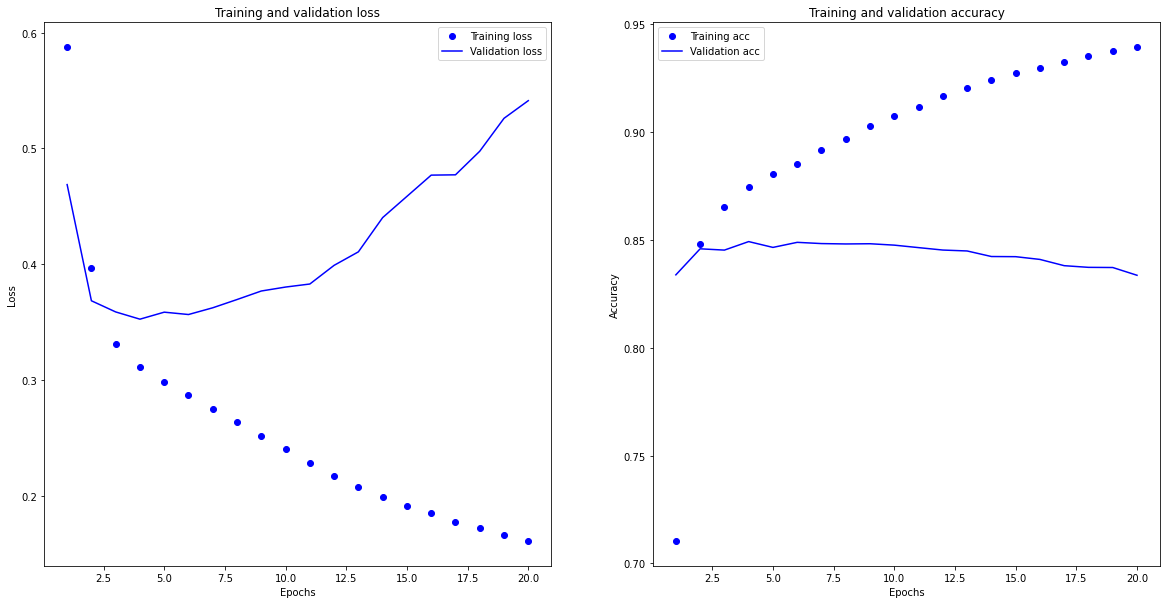

In [25]:
# RNN 모델 Loss, Accuracy 그래프 시각화

history_rnn_dict = history_rnn.history

acc = history_rnn_dict['accuracy']
val_acc = history_rnn_dict['val_accuracy']
loss = history_rnn_dict['loss']
val_loss = history_rnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

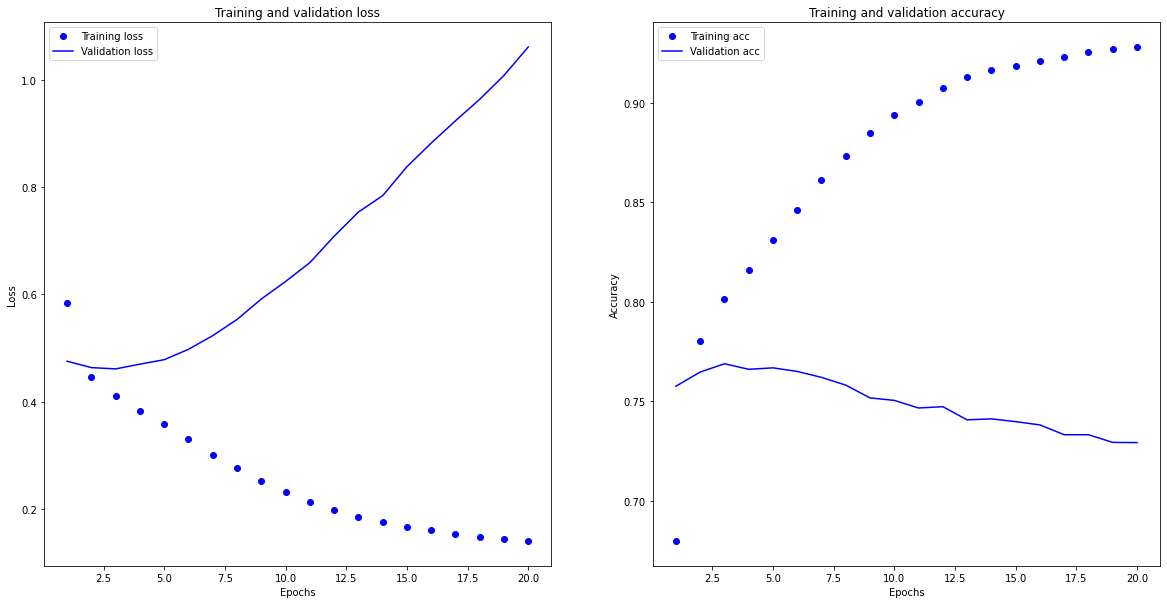

In [26]:
# CNN 모델 Loss, Accuracy 그래프 시각화

history_cnn_dict = history_cnn.history

acc = history_cnn_dict['accuracy']
val_acc = history_cnn_dict['val_accuracy']
loss = history_cnn_dict['loss']
val_loss = history_cnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

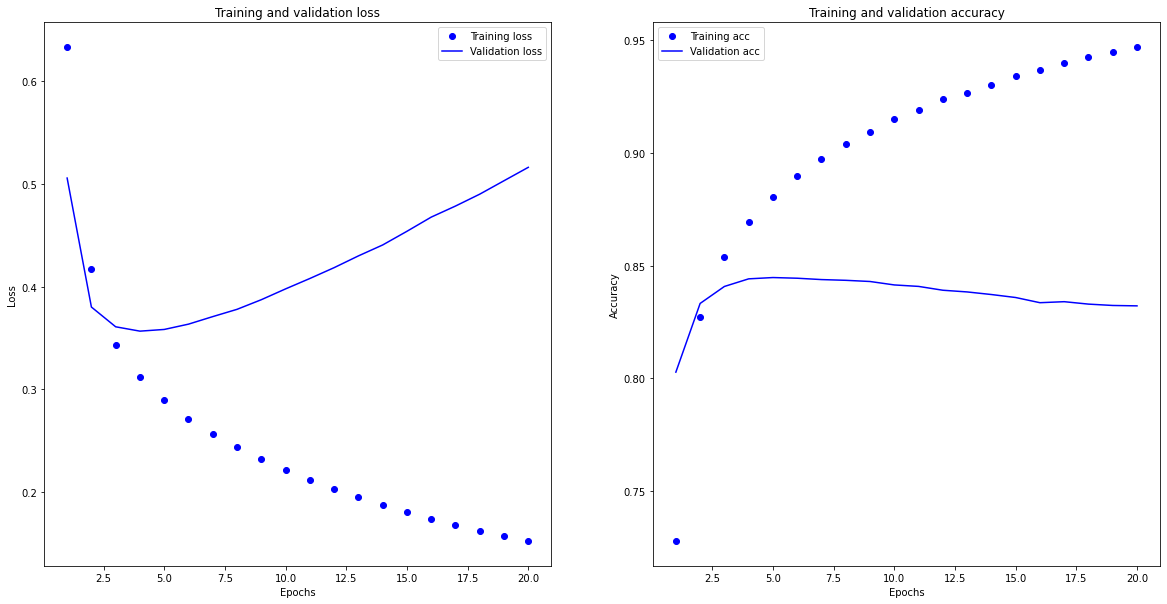

In [27]:
# GlobalMaxPooling1D() 모델 Loss, Accuracy 그래프 시각화

history_gmp_dict = history_gmp.history

acc = history_gmp_dict['accuracy']
val_acc = history_gmp_dict['val_accuracy']
loss = history_gmp_dict['loss']
val_loss = history_gmp_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding 레이어 분석

In [64]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

In [66]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [68]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [70]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑") # 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인

[('사라질', 0.9634609818458557),
 ('구매', 0.9605350494384766),
 ('빠질', 0.9563460946083069),
 ('훌쩍', 0.9541800022125244),
 ('돌아보', 0.9524162411689758),
 ('ㅠㅠㅠㅠ', 0.9517741799354553),
 ('풍부', 0.9498653411865234),
 ('설렘', 0.9483941793441772),
 ('짠', 0.9477145671844482),
 ('명품', 0.9462499022483826)]

### Google의 Word2Vec 모델을 가져와 적용

In [59]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000) # 상위 100만 개만 limt으로 조건을 주어 로딩
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [60]:
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

우수프로젝트 권승님 글 참조
* 먼저 gensim 패키지의 버전을 확인하자. (2021.08.17 내용 수정)
* 프로젝트 수행 과정에서 gensim 패키지의 버전을 다운그레이드하였다. 이유는 한국어Word2Vec 파일을 잘 불러오지 못하는 문제 때문이었다.
* pip install --upgrade gensim==3.8.3 명령어를 Cloud Shell에 입력해 주어 한국어 파일인 ko_model을 정상적으로 불러올 수 있었다.

In [1]:
# gensim 패키지 버전 알아보기

import gensim
gensim.__version__

'3.8.3'

In [72]:
!pip install --upgrade gensim==3.8.3

  Using cached gensim-3.8.3-cp39-cp39-linux_x86_64.whl


In [16]:
import os
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)

In [17]:
# 유사한 단어와 그 유사도 확인
ko_model.wv.most_similar("당신")

[('여러분', 0.6857219934463501),
 ('그대', 0.6845344305038452),
 ('너희', 0.6703404188156128),
 ('그분', 0.6606594324111938),
 ('내가', 0.6512429714202881),
 ('자신', 0.6209174394607544),
 ('하느님', 0.6158164739608765),
 ('저희', 0.6040840744972229),
 ('누군가', 0.603564977645874),
 ('정말', 0.5843536853790283)]

In [18]:
# 유사한 단어와 그 유사도 확인
ko_model.wv.most_similar("눈물")

[('땀', 0.6310575008392334),
 ('슬픔', 0.5787195563316345),
 ('이별', 0.5772002935409546),
 ('추억', 0.5725258588790894),
 ('한숨', 0.5546674728393555),
 ('슬프', 0.5339798927307129),
 ('웃음', 0.5284000039100647),
 ('울부짖', 0.5240477323532104),
 ('울음', 0.5148942470550537),
 ('온몸', 0.5059491395950317)]

In [33]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 카피
for i in range(4, vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/tmp/ipykernel_87/3932605460.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_model:
/tmp/ipykernel_87/3932605460.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_model[index_to_word[i]]


In [39]:
import tensorflow as tf
from tensorflow.keras.initializers import Constant

# RNN Word2Vec embedding 활용
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_rnn = model_rnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 3s 9ms/step - loss: 0.1098 - accuracy: 0.9639 - val_loss: 0.5788 - val_accuracy: 0.8342
Epoch 2/20
208/208 [==============================] - 1s 7ms/step - loss: 0.1050 - accuracy: 0.9655 - val_loss: 0.5923 - val_accuracy: 0.8317
Epoch 3/20
208/208 [==============================] - 1s 7ms/step - loss: 0.1018 - accuracy: 0.9669 - val_loss: 0.5906 - val_accuracy: 0.8340
Epoch 4/20
208/208 [==============================] - 1s 7ms/step - loss: 0.0999 - accuracy: 0.9675 - val_loss: 0.6061 - val_accuracy: 0.8341
Epoch 5/20
208/208 [==============================] - 1s 7ms/step - loss: 0.0953 - accuracy: 0.9690 - val_loss: 0.6129 - val_accuracy: 0.8303
Epoch 6/20
208/208 [==============================] - 1s 7ms/step - loss: 0.0922 - accuracy: 0.9704 - val_loss: 0.6341 - val_accuracy: 0.8328
Epoch 7/20
208/208 [==============================] - 1s 7ms/step - loss: 0.0882 - accuracy: 0.9718 - val_loss: 0.6672 - val_accuracy: 0.8283
Epoch 

In [49]:
# RNN 모델을 테스트셋으로 평가
results_rnn = model_rnn.evaluate(X_test,  y_test, verbose=2)
print(results_rnn)

1537/1537 - 3s - loss: 0.5917 - accuracy: 0.8284
[0.5917215943336487, 0.8283662796020508]


In [42]:
# CNN Word2Vec embedding 활용
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          9616      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [43]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_cnn = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 4s 8ms/step - loss: 0.6508 - accuracy: 0.6131 - val_loss: 0.5825 - val_accuracy: 0.6781
Epoch 2/20
208/208 [==============================] - 1s 6ms/step - loss: 0.5390 - accuracy: 0.7179 - val_loss: 0.5190 - val_accuracy: 0.7287
Epoch 3/20
208/208 [==============================] - 1s 6ms/step - loss: 0.4792 - accuracy: 0.7592 - val_loss: 0.4920 - val_accuracy: 0.7487
Epoch 4/20
208/208 [==============================] - 1s 6ms/step - loss: 0.4395 - accuracy: 0.7844 - val_loss: 0.4820 - val_accuracy: 0.7517
Epoch 5/20
208/208 [==============================] - 1s 6ms/step - loss: 0.4107 - accuracy: 0.8011 - val_loss: 0.4794 - val_accuracy: 0.7597
Epoch 6/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3859 - accuracy: 0.8139 - val_loss: 0.4855 - val_accuracy: 0.7600
Epoch 7/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3657 - accuracy: 0.8239 - val_loss: 0.4930 - val_accuracy: 0.7610
Epoch 

In [44]:
# CNN 모델을 테스트셋으로 평가
results_cnn = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results_cnn)

1537/1537 - 3s - loss: 0.8831 - accuracy: 0.7400
[0.8830965757369995, 0.7399556636810303]


In [45]:
# GlobalMaxPooling1D() 모델 Word2Vec embedding 활용
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_gmp = model_gmp.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 2s 5ms/step - loss: 0.6637 - accuracy: 0.5986 - val_loss: 0.6091 - val_accuracy: 0.6765
Epoch 2/20
208/208 [==============================] - 1s 4ms/step - loss: 0.5718 - accuracy: 0.7062 - val_loss: 0.5395 - val_accuracy: 0.7336
Epoch 3/20
208/208 [==============================] - 1s 5ms/step - loss: 0.5125 - accuracy: 0.7517 - val_loss: 0.4975 - val_accuracy: 0.7590
Epoch 4/20
208/208 [==============================] - 1s 5ms/step - loss: 0.4703 - accuracy: 0.7784 - val_loss: 0.4679 - val_accuracy: 0.7773
Epoch 5/20
208/208 [==============================] - 1s 4ms/step - loss: 0.4377 - accuracy: 0.7982 - val_loss: 0.4476 - val_accuracy: 0.7880
Epoch 6/20
208/208 [==============================] - 1s 4ms/step - loss: 0.4115 - accuracy: 0.8146 - val_loss: 0.4309 - val_accuracy: 0.7982
Epoch 7/20
208/208 [==============================] - 1s 4ms/step - loss: 0.3887 - accuracy: 0.8266 - val_loss: 0.4225 - val_accuracy: 0.8047
Epoch 

In [47]:
# GlobalMaxPooling1D 모델을 테스트셋으로 평가
results_gmp = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results_gmp)

1537/1537 - 2s - loss: 0.4271 - accuracy: 0.8238
[0.42713651061058044, 0.8238094449043274]


## 후기

* 권승민님의 글 처럼 pip install --upgrade gensim==3.8.3 명령어 실행에 오류가 떠 삭제 후 다시 재 설치해도 관리자와 권한 문제가 있다는 경고문이 뜨면서 제대로 작동하지 않았음. 몇번이나 사이트를 나갔다 다시 들어와서 재 시도 끝에 제대로 버전 다운되고 한국어 Word2Vec 사용이 가능했음.

* 훈련데이터만으로는 워드 벡터를 학습시켰을때 유사한 단어와 유사도를 확인해보면 유사도는 0.9 이상 높게 나오지만 단어 의미상 크게 유사함을 느낄 수 없었으나 한국어 Word2Vec 사용시엔 유사도는 0.5~0.6 사이로 낮은 편이나 의미상 유사한 부분이 많음을 알 수 있음.

* Word2Vec embedding 활용 시 같은 조건에서의 모델 정확도는 약 0.1~0.2 사이로 높아졌으나 85%에 도달하지 못함.
* Loss, Accuracy 그래프 시각화를 통해 확인한 정보를 모델에 적절히 반영하지 못함...epoch 수정 후 정확도 오히려 낮아졌었음. ㅠㅠ
